# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks- databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Jag använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Zemer6969")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\kaisa\AppData\Local\Temp\ipykernel_30692\2621769548.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
1. JOINa tabellerna 
2. Räkna DISTINCT produkt per kategori
3. Skapa verikalt stapeldiagram
4. Analysera resultatet

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT (DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
LEFT JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

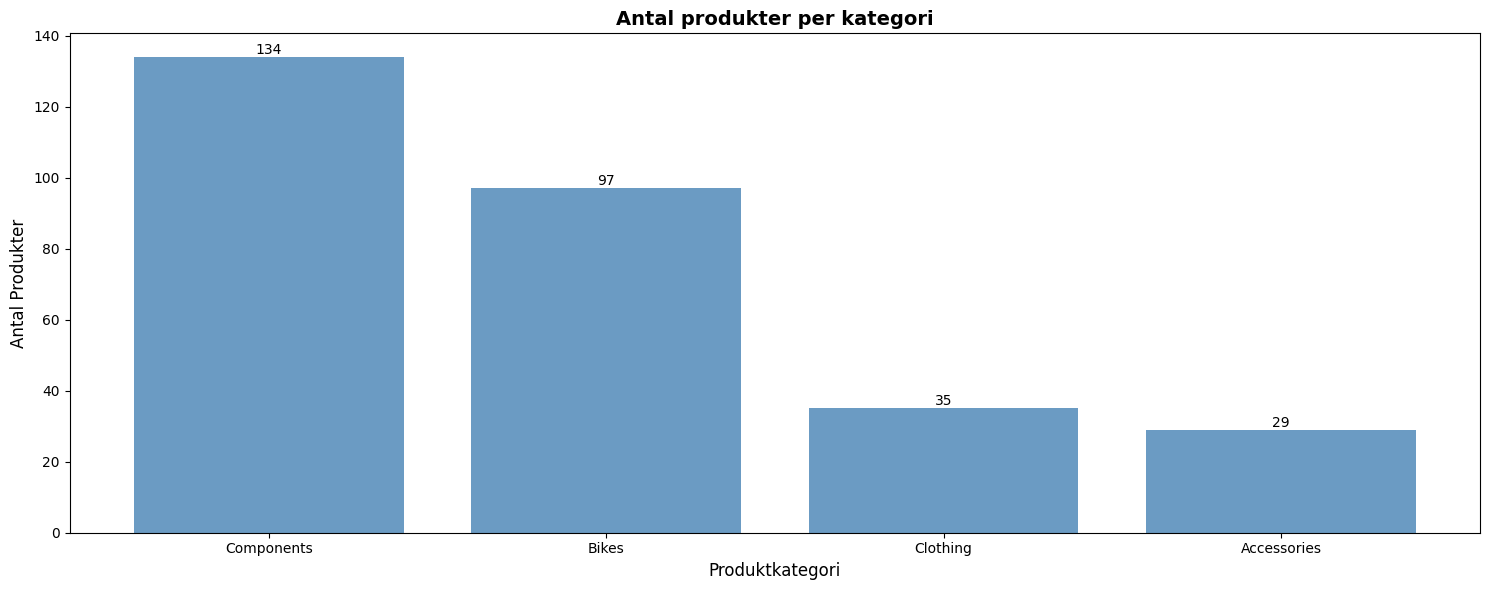

In [4]:
fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha= 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width()/2,
    height,
    f'{int(height)}',
    ha = 'center',
    va = 'bottom'
    )

ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal Produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
- **Components** är **största kategorin** med 134 produkter.
- **Accessories** är **minst** med 29 produkter.

Detta indikerar på att företaget är stark fokuserad på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory,
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
1. JOINa tabellerna 
2. Få fram vilken kategori som är störst och minst, med exakta siffror med hjälp av SUM 
3. Skapa horisontellt stapeldiagram (barh)
4. Analysera resultatet

In [5]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    CAST(SUM (sod.LineTotal) AS decimal(18,2)) AS TotalOmsättning
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID

GROUP BY pc.Name
ORDER BY TotalOmsättning DESC;
"""

df_vis2 = query_df(query_vis2)

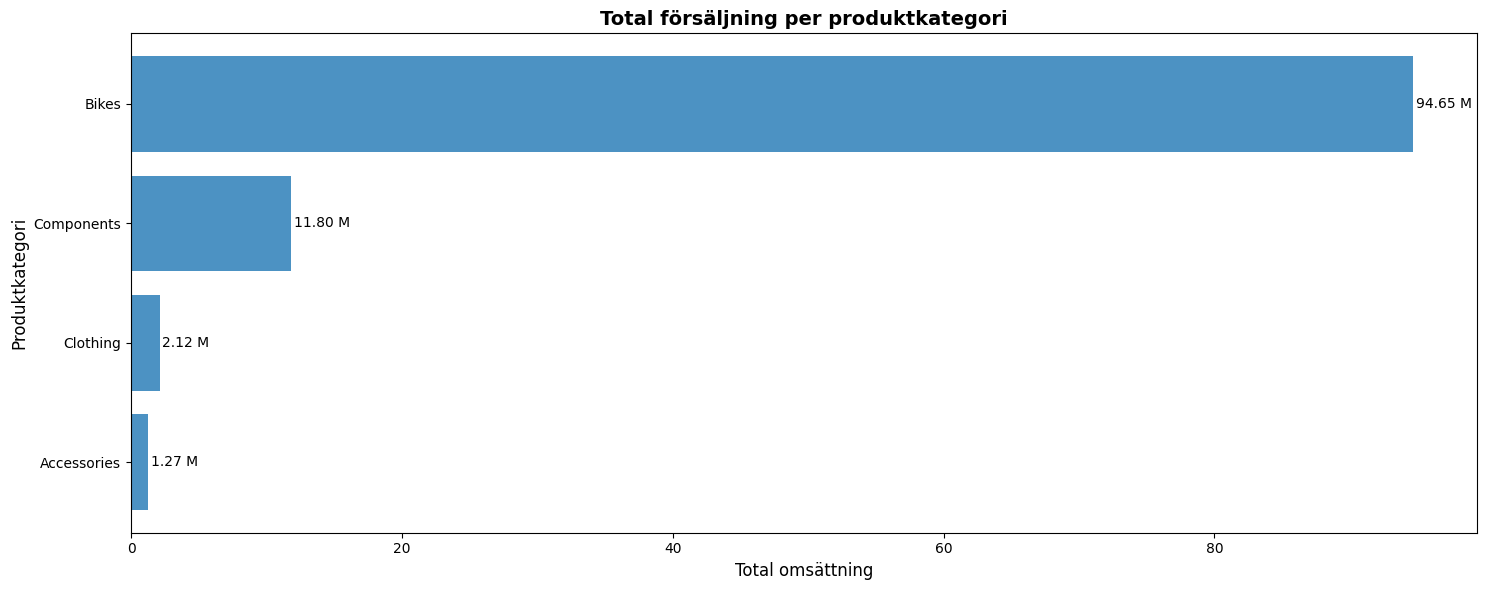

In [6]:
df_vis2 = df_vis2.sort_values('TotalOmsättning', ascending = False)
df_vis2 = df_vis2.iloc[::-1]                                            # störst överst

fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalOmsättning']/ 1_000_000,                               # i miljoner
    alpha = 0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height()/ 2,
        f'{width:.2f} M',
        va = 'center'
    )

ax.set_xlabel('Total omsättning', fontsize = 12)
ax.set_ylabel('Produktkategori', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori

- Kategorin **Bikes** är den som genererar **högst omsättning** med ~ 94,7 miljoner, följt av Components ~ 11,8 miljoner.

- Omsättningen är beräknad med hjälp av LineTotal, vilket inkluderar eventuella rabatter och därför ger en mer korrekt och rymlig bild av faktisk försäljning 

- Kategori **Accessories** säljer **minst** med omsättning på ungefär 1,27 miljoner (största utvecklingsområde).


## Visualisering 3: Försäljning över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
1. Aggregera per månad (minst 12 månader data) 
2. Få fram trenden - ökar försäljning, minskar den, är den säsongsberoende? Vilka är högsta och lägsta månaden? Använda CAST(SUM) samt DATEADD.
3. Skapa linjediagram
4. Analysera resultatet

In [7]:
query_vis3 = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    CAST(SUM(TotalDue) AS decimal(18,2)) AS TotalSales
FROM Sales.SalesOrderHeader
WHERE 
    OrderDate >= (
        SELECT DATEADD(MONTH, -12, MAX(OrderDate))
        FROM Sales.SalesOrderHeader
    )
GROUP BY
    FORMAT(OrderDate, 'yyyy-MM')
ORDER BY
    YearMonth ASC;
"""

df_vis3 = query_df(query_vis3)

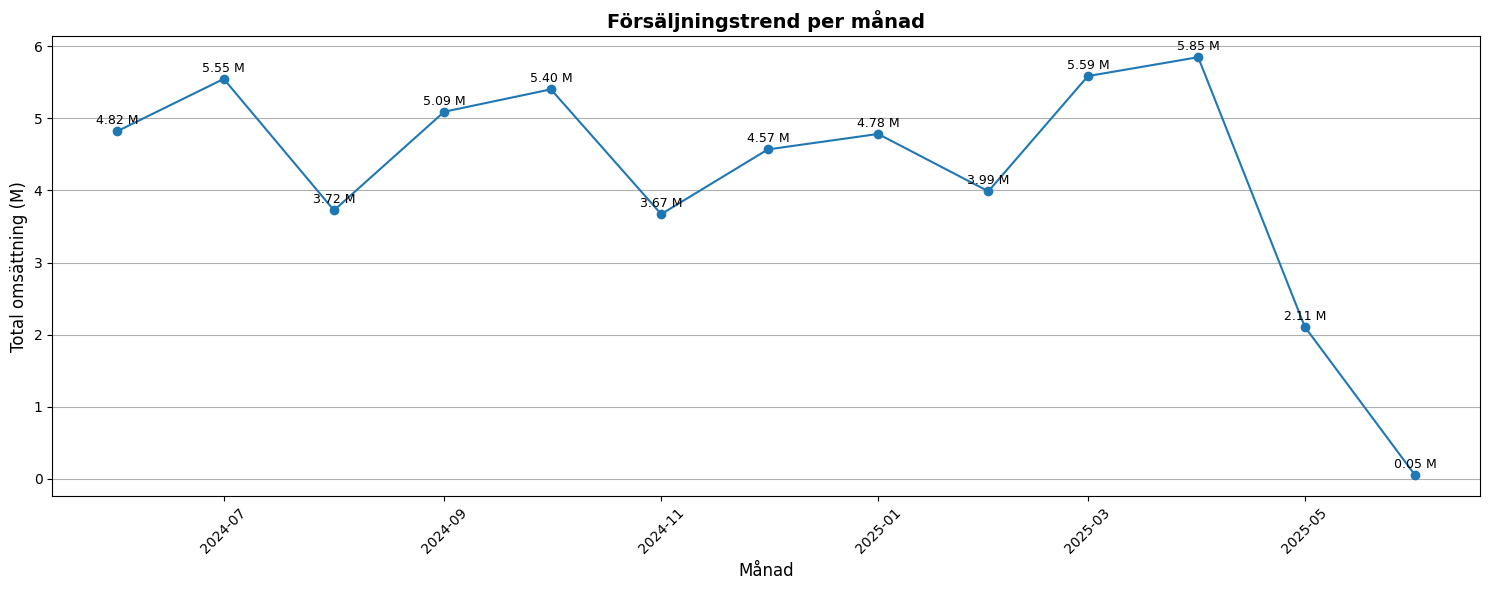

In [ ]:
from matplotlib.ticker import FuncFormatter

df_vis3['YearMonth'] = pd.to_datetime(df_vis3['YearMonth'])
df_vis3['TotalSales'] = pd.to_numeric(df_vis3['TotalSales'], errors='coerce')
df_vis3 = df_vis3.dropna(subset=['TotalSales']).sort_values('YearMonth')

df_vis3['TotalSales_M'] = df_vis3['TotalSales'] / 1_000_000                     # visar i miljoner även här

fig, ax = plt.subplots(figsize = (15, 6))

ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales_M'], marker="o", linestyle="-")

ax.set_title('Försäljningstrend per månad', fontsize= 14, fontweight= 'bold')
ax.set_xlabel('Månad', fontsize = 12)
ax.set_ylabel('Total omsättning (M)', fontsize = 12)
ax.grid(True, axis='y')
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation= 45)                                                        # roterar texten med 45 grader

for x, y in zip(df_vis3['YearMonth'], df_vis3['TotalSales_M']):                 # fixar synliga siffror i (M) ovanpå varje "o"
    ax.text(
        x,
        y + 0.1,
        f'{y:.2f} M',
        ha = 'center',
        fontsize = 9
    )

plt.tight_layout()
plt.show()

### Insikter- Försäljningstrend över tid

- Vissa månader uppvisar högre försäljning (toppar) vilket kan tyda på en säsongsvariation. 
- Den **högsta** försäljningen är i **april 2025 (≈5.85 miljoner)**
- Den **lägsta** fullständiga månaden är **november 2024 (≈3.67 miljoner)**
- Den sista månaden i tidserien (2025-06) är ofullständigt och innehåller endast ett fåtal order, vilket förklarar den betydligt lägre försäljningssiffran jämfört med de övriga månaderna (den visar kraftig nedgång).

## Visualisering 4: Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
1. Visa både total försäljning och antal ordrar.
2. Jämföra åren - vilket år hade högst försäljning? Ökar både försäljning och antal ordrar, eller bara det ena? Använda YEAR, CAST och COUNT.
3. Skapa grupperat stapeldiagram.
4. Analysera resultatet

In [9]:
query_vis4 = """
SELECT 
    YEAR(OrderDate) AS OrderYear,
    CAST(SUM(TotalDue) AS decimal(18,2)) AS TotalSales,
    COUNT(SalesOrderID) AS AntalOrdar
FROM Sales.SalesOrderHeader
GROUP BY
    YEAR(OrderDate)
ORDER BY
    OrderYear ASC;
"""

df_vis4 = query_df(query_vis4)

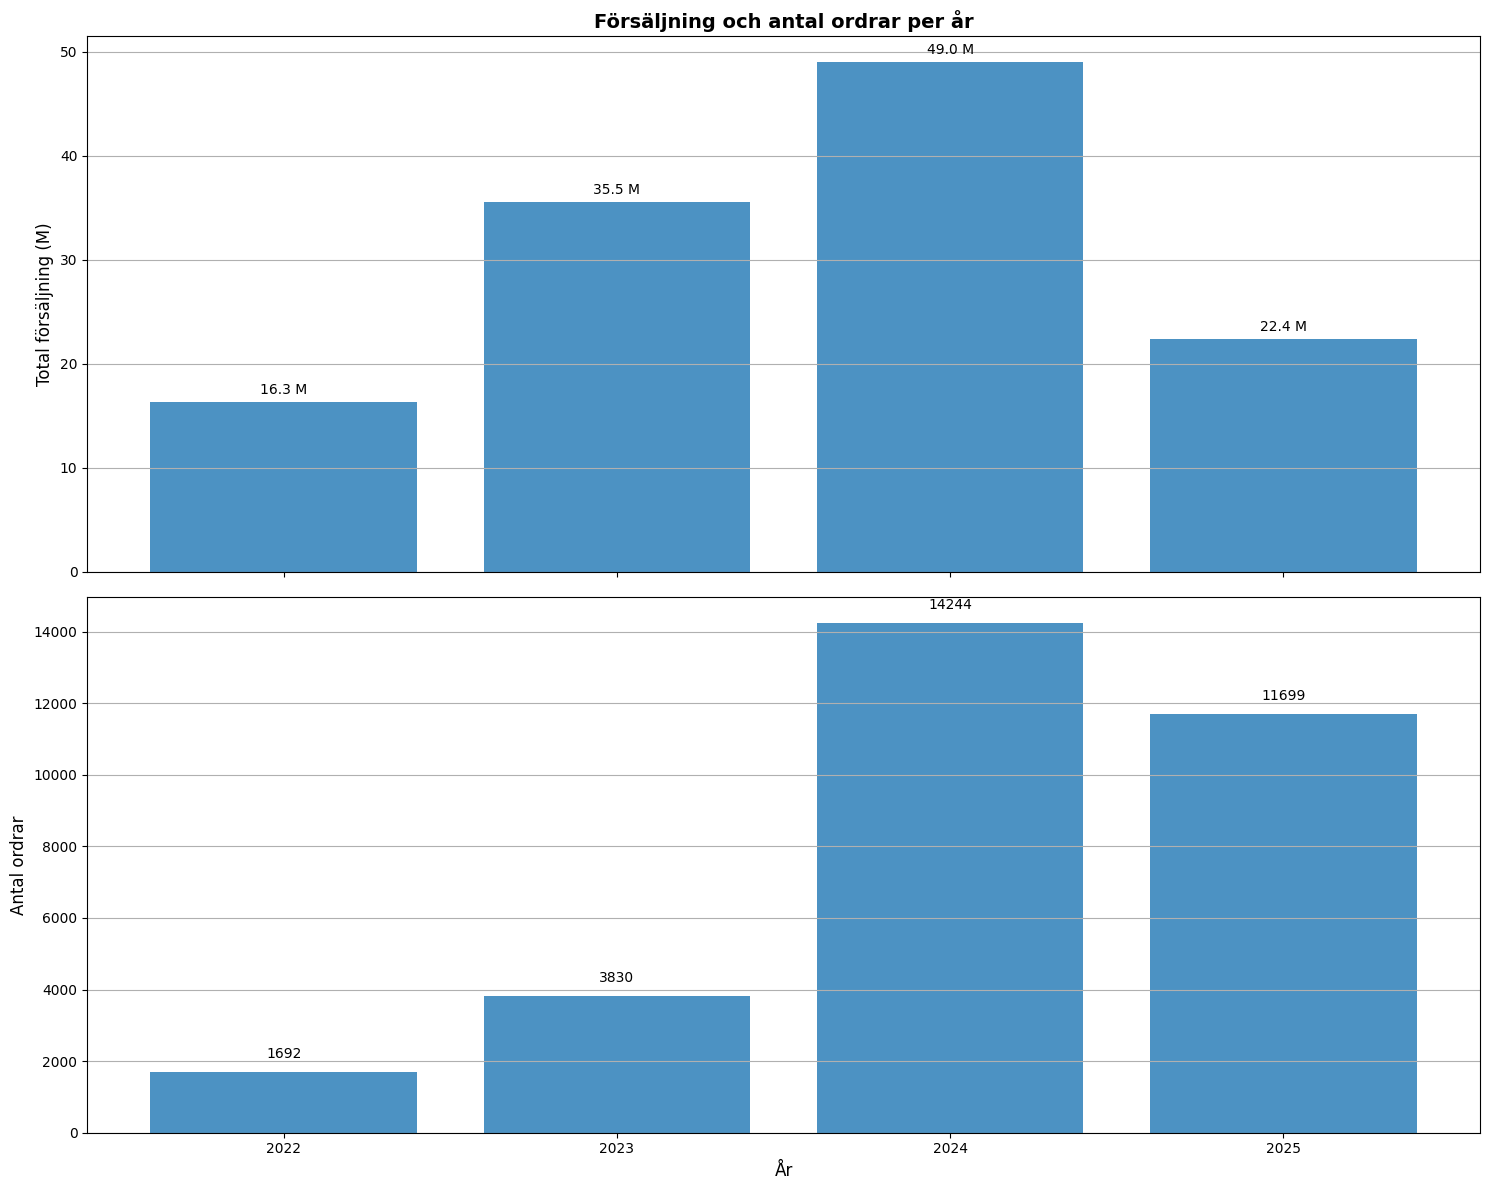

In [ ]:
take = df_vis4[['OrderYear', 'TotalSales', 'AntalOrdar']].dropna().copy().sort_values("OrderYear")
take['TotalSales_M'] = take['TotalSales'] / 1_000_000

fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (15, 12), sharex = True)

bars_sales = ax1.bar(take['OrderYear'], take['TotalSales_M'], alpha = 0.8)                  # två olika grafer, sales = försäljnings diagram, med tittel, label, siffror ovanpå staplarna
ax1.set_title('Försäljning och antal ordrar per år', fontsize= 14, fontweight= 'bold')
ax1.set_ylabel('Total försäljning (M)', fontsize = 12)
ax1.grid(True,axis="y")

for b in bars_sales:
    ax1.text(
        b.get_x() + b.get_width()/ 2,
        b.get_height() + 0.5,
        f'{b.get_height():.1f} M',
        ha = 'center',
        va = 'bottom',
        fontsize = 10
    )

bars_orders = ax2.bar(take['OrderYear'], take['AntalOrdar'], alpha = 0.8)                   # diagram med antal ordrar, med labels och värden ovanpå staplarna även här
ax2.set_ylabel('Antal ordrar', fontsize= 12)
ax2.set_xlabel('År', fontsize = 12)
ax2.grid(True,axis="y")

for b in bars_orders:
    ax2.text(
        b.get_x() + b.get_width()/ 2,
        b.get_height() + 300,
        f'{int(b.get_height())}',
        ha = 'center',
        va = 'bottom',
        fontsize = 10
    )

ax2.set_xticks(take['OrderYear'])

plt.tight_layout()
plt.show()

### Insikter -  Försäljning och antal ordrar per år

- Total försäljning och antal ordrar ökar tydligt mellan 2022 och 2024. 
- År **2024** är det **starkaste året** med både högsta omsättning (cirka 49 miljoner) och flest antal ordrar (14 244). Man märker tillväxten i verksamheten.
- År **2025** visar **lägre totalförsäljning** (cirka 22,4 miljoner) trots ett relativt högt antal ordrar (11 699). Det kan finnas en förklaring i att året är **ofullständigt** och innehåller data fram till mitten av året (juni). 
- Sammanfattningsvis så ser man att försäljning och antal ordrar har ökat parallellt, men 2024 var en tydligt toppår.

## Visualisering 5: Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

Tabeller som används:
- Production.Product
- Sales.SalesOrderDetail

Plan:
1. Visa både total försäljning och antal ordrar.
2. Nämna #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10? Använda TOP och JOINa tabellerna.
3. Skapa horisontellt stapeldiagram.
4. Analysera resultatet.

In [11]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProduktNamn,
    SUM(sod.LineTotal) AS Försäljningsvärde,
    SUM(sod.OrderQty) AS AntalSåldaProdukter
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY Försäljningsvärde DESC;
"""

df_vis5 = query_df(query_vis5) 

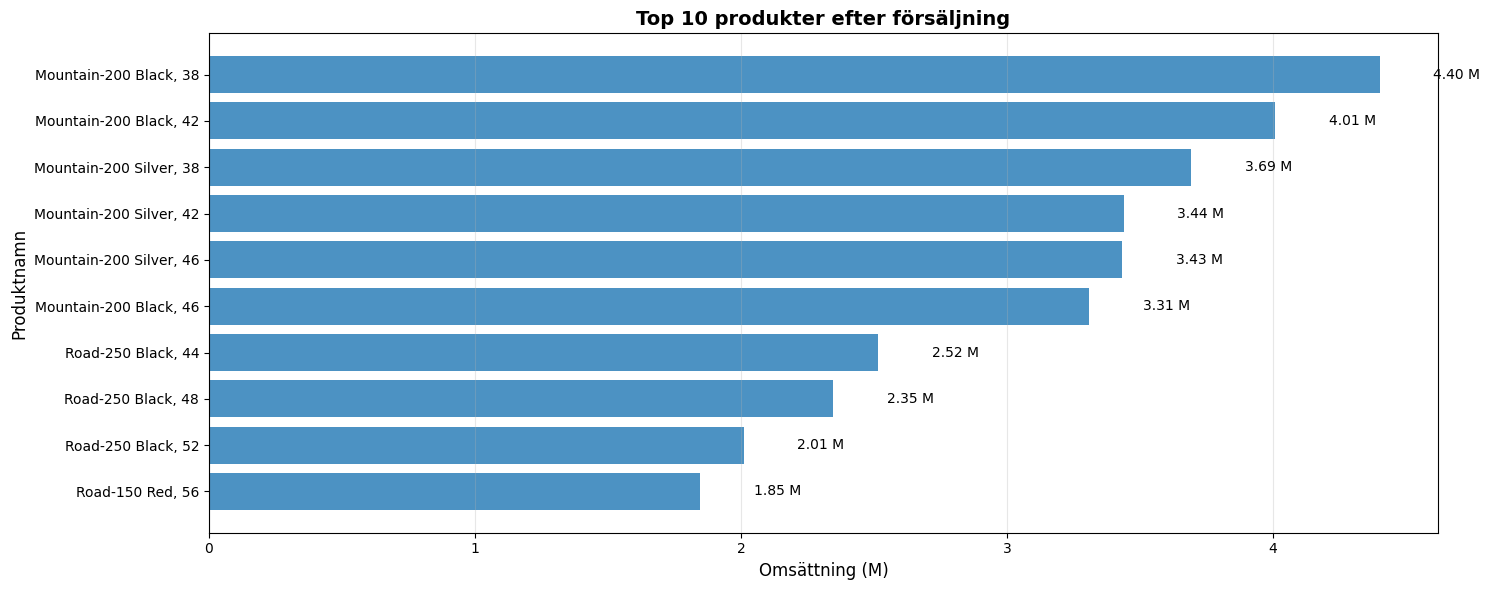

In [ ]:
df_vis5 = df_vis5.sort_values('Försäljningsvärde', ascending = False)
df_vis5 = df_vis5.iloc[::-1]                                                # störst överst

fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.barh(
    df_vis5['ProduktNamn'],
    df_vis5['Försäljningsvärde']/ 1_000_000,                                 # i miljoner
    alpha = 0.8
)

for bar in bars:                                                             # värderna visas strax vid stapeln
    width = bar.get_width()
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height()/ 2,
        f'{width:.2f} M',
        va = 'center'
    )

ax.set_xlabel('Omsättning (M)', fontsize = 12)
ax.set_ylabel('Produktnamn', fontsize = 12)
ax.set_title('Top 10 produkter efter försäljning', fontsize= 14, fontweight = 'bold')
ax.grid(True, axis = 'x', alpha = 0.3)
plt.tight_layout()
plt.show()

### Insikter - Top 10 produkter

- Analysen visar att **Mountain -200 Black, 38** är den produkten som, genererar högst försäljning med ett totalt försäljningsvärde på **4 400 592.80** med exakt **2977 sålda exemplar** .
- **Topplistan domineras** tydligt av cykelprodukter, framförallt från **Mountain och Road segmenten**, vilket indikerar att **kategorin Bikes** står för den **största delen av försäljningen** bland de tio mest lönsamma produkterna. 
- Även om Kategoritabellen (Production.ProductCategory) inte används i SQL, kan man utifrån produktnamnen se att majoriteten av top-10 tillhör cyklarna. 

## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:
1. Visa total försäljning och antal unika kunder per region.
2. Hitta vilken region är starkast/svagast? Jämföra: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det? Använda COUNT DISTINCT för unika kunder och CAST SUM för total försäljning. 
3. Skapa en grupperat stapeldiagram (grouped bar) med två staplar per region (En stapel för försäljning, en stapel för antal kunder).
4. Analysera resultatet.

In [13]:
query_vis6 = """
SELECT 
    st.Name AS RegionName,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers,
    CAST(SUM(soh.TotalDue) AS decimal(18,2)) AS TotalSales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df_vis6 = query_df(query_vis6)

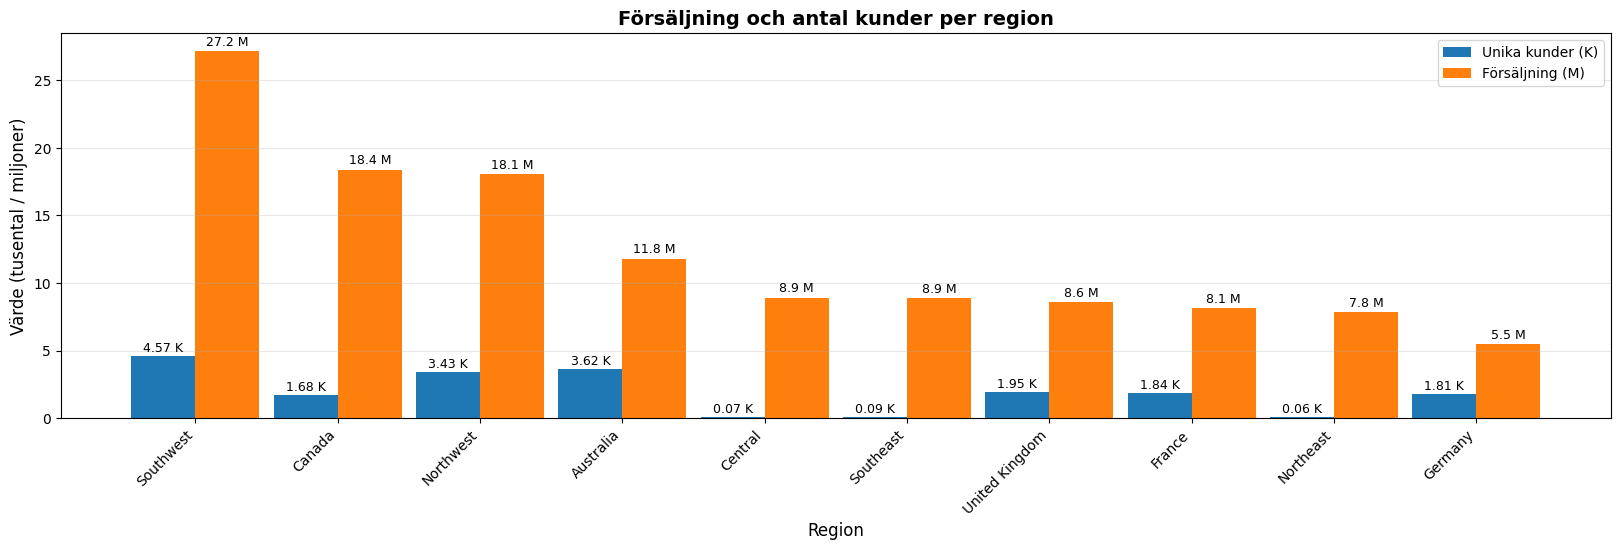

In [ ]:
take = df_vis6[["RegionName", "UniqueCustomers", "TotalSales"]].dropna().copy()
take = take.sort_values("TotalSales", ascending = False)
take["TotalSales_M"] = take["TotalSales"] / 1_000_000                               # visar i miljoner
take["UniqueCustomers_K"] = take["UniqueCustomers"] / 1000                          # visar i K- tusen

fig, ax = plt.subplots(figsize= (20, 5))

idx = np.arange(len(take)) 
width = 0.45

bars_cust = ax.bar(idx - width/2, take["UniqueCustomers_K"], width= width, label="Unika kunder (K)")        # customers diagram
bars_sales = ax.bar(idx + width/2, take["TotalSales_M"], width= width, label= "Försäljning (M)")            # försäljningsdiagram

ax.set_xticks(idx)
ax.set_xticklabels(take["RegionName"], rotation=45, ha="right")
ax.set_title("Försäljning och antal kunder per region", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Region", fontsize = 12)
ax.set_ylabel("Värde (tusental / miljoner)", fontsize = 12)
ax.grid(True, axis="y", alpha = 0.3)
ax.legend()

for b in bars_cust:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1,
            f"{b.get_height():.2f} K", ha = "center", va = "bottom", fontsize = 9)
    
for b in bars_sales:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.2,
            f"{b.get_height():.1f} M", ha = "center", va = "bottom", fontsize = 9)

plt.show()

### Insikter -  Försäljning och antal kunder per region

- **Regionen Southwest** är den **starkaste** regionen, när det handlar om **total försäljning (~27,2 M)** men har även **flest unika kunder (4565)**. Detta indikerar att den höga omsätttningen främst drivs av en stor kundbas.
- Regionen **Canada och Northwest** uppvisar **relativt hög försäljning (~18 M)** trots **färre kunder**. Det kan tyda på ett högre genomsnittligt ordervärde per kund. 
- De svagaste regionerna: **Northeast och Central**, har både **låg försäljning och få kunder** (50-90), vilket kan betyda mindre marknader snarare än låg köpkraft.
- Det är ingenting som ser 'orimligt högt' eller duplicerat ut, som betyder att Joins + COUNT DISTINCT fungerar korrekt. 

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:
1. Visa total försäljning och antal ordrar per region.
2. Jämföra Store vs Individual - vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde? Kommer att använda mig av CASE-WHEN både i SELECT men även i GROUP BY. JOINa tabellerna på rätt sätt samt räkna ut med SUM, COUNT-DISTINCT,mm.
3. Skapa en grupperat stapeldiagram (grouped bar) med två staplar per region (En stapel för Store, en stapel för Individual).
4. Analysera resultatet.

In [15]:
query_vis7 = """
;WITH SalesByRegionAndCustomerType AS (
    SELECT 
        st.Name AS RegionName,
        CASE
            WHEN c.StoreID IS NOT NULL THEN 'Store'
            WHEN c.PersonID IS NOT NULL THEN 'Individual'
            ELSE 'Unknow Customer Type'
    END AS CustomerType,
    COUNT(DISTINCT soh.SalesOrderID) AS NumberOfOrders,
    SUM(soh.TotalDue) AS TotalSales,
    SUM(TotalDue) / NULLIF(COUNT (DISTINCT soh.SalesOrderID), 0) AS AvgOrderValue

FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s ON c.StoreID = s.BusinessEntityID

GROUP BY st.Name,
 CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        WHEN c.PersonID IS NOT NULL THEN 'Individual'
        ELSE 'Unknow Customer Type'
    END
),

RegionRank AS (
    SELECT
        RegionName,
        SUM(TotalSales) / NULLIF(SUM(NumberOfOrders), 0) AS AvgOrderValue_Total
    FROM SalesByRegionAndCustomerType  
    GROUP BY RegionName
)

SELECT
    srct.RegionName,
    srct.CustomerType,
    CAST(srct.TotalSales AS decimal(18,2)) AS TotalSales,
    srct.NumberOfOrders,
    CAST(srct.AvgOrderValue AS decimal(18,2)) AS AvgOrderValue

FROM SalesByRegionAndCustomerType srct  
JOIN RegionRank r ON srct.RegionName = r.RegionName

ORDER BY 
    r.AvgOrderValue_Total DESC,
    srct.CustomerType ASC;

"""

df_vis7 = query_df(query_vis7)

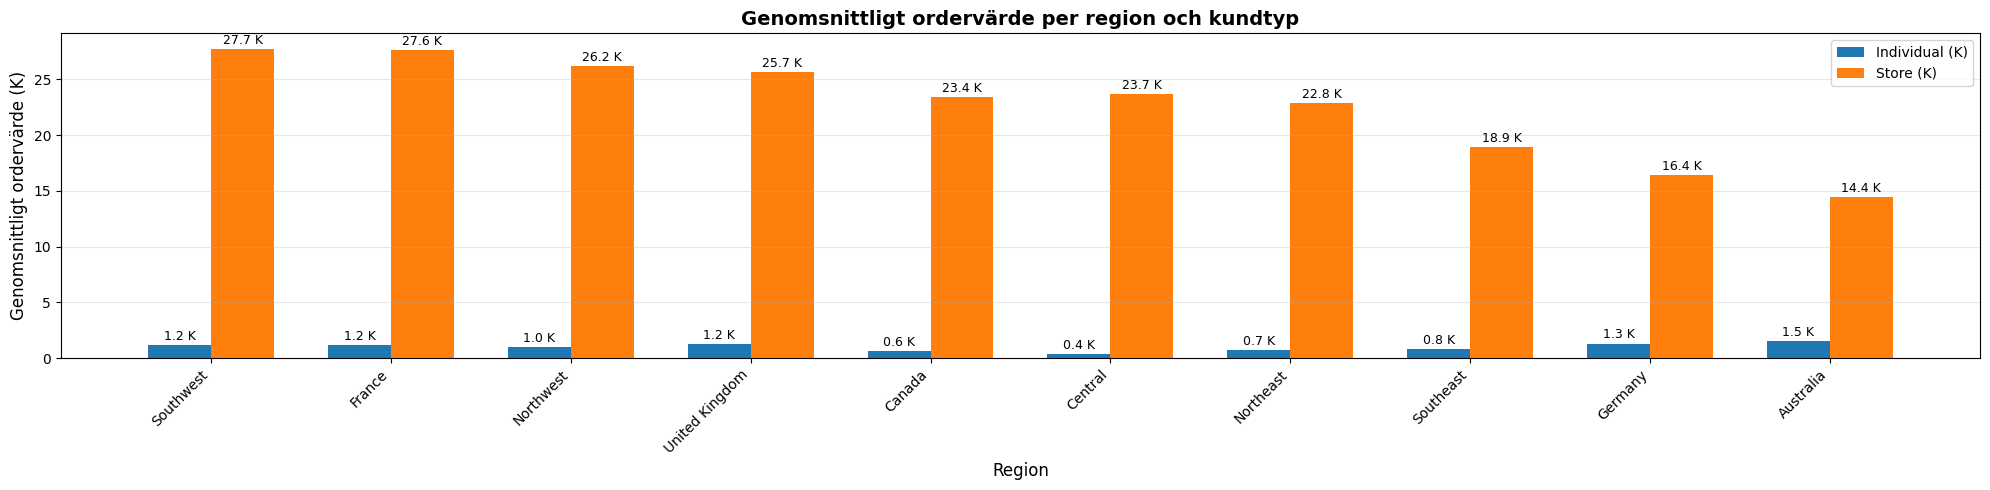

In [ ]:
take = df_vis7[["RegionName", "CustomerType", "AvgOrderValue"]].dropna().copy()

pivot = take.pivot(index = "RegionName", columns = "CustomerType", values = "AvgOrderValue")    # använder pivot för lättare hantering
pivot = pivot.fillna(0)                                                                         # ifall någon region saknar typ
pivot["TotalAvg"] = pivot.sum(axis=1)
pivot = pivot.sort_values("TotalAvg", ascending = False)                                        # stora regioner efter högst genomsnitt (store + individual)
pivot = pivot.drop(columns = "TotalAvg")

pivot_k = pivot / 1000                                                                          # skala till k (tusen)

fig, ax = plt.subplots(figsize= (20, 5))
idx = np.arange(len(pivot_k))
width = 0.35

bars_ind = ax.bar(idx - width/2, pivot_k.get("Individual", 0), width= width, label="Individual (K)")        # staplar för individuella kunder
bars_store = ax.bar(idx + width/2, pivot_k.get("Store", 0), width= width, label= "Store (K)")               # staplar för store

ax.set_xticks(idx)
ax.set_xticklabels(pivot_k.index, rotation=45, ha="right")
ax.set_title("Genomsnittligt ordervärde per region och kundtyp", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Region", fontsize = 12)
ax.set_ylabel("Genomsnittligt ordervärde (K)", fontsize = 12)
ax.grid(True, axis="y", alpha = 0.3)
ax.legend()

# fixar siffror ovanpå staplar:
for bars in [bars_ind, bars_store]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.2, f"{h:.1f} K", ha = "center", va = "bottom", fontsize = 9)
    
plt.tight_layout()
plt.show()

### Insikter - Genomsnittligt ordervärde per region och kundtyp

- Företagskunder (Store) har betydligt högre genomsnittligt ordervärde än individuella kunder (Inividual) i samtliga regioner. 
Det kan betyda att företagskunder gör färre men större inköp, medan privatpersoner handlar oftare men för mycket mindre pengar/ lägre ordervärde. 
- **Southwest - Store (≈27 739)** är den regionen + kundtypen som har absolut det **högsta genomsnittliga ordervärdet**.
- Även regioner som **France och Central** uppvisar **höga genomsnittliga ordervärden** för Store-kunderna, trots att deras antal ordrar är relativt låg. I dessa regioner verkar företagskundsbasen vara mindre men mer köpstark.
- Individuella kunder har lägst snitt-ordervärde i samtliga regioner, men särskilt **låga värden ser vi i Canada och Central**. Som jag tidigare har nämnt, kan det indikera på att privatkunder står mer för volym än för högt ordervärde per köp.
- Skillnaderna mellan Store och Individual är **konsekventa** och tydliga över alla regioner. Det betyder definitivt att **kundtyp har större påverkan** på ordervärde än geografisk region. 


*Sammanfattning : Privatkunder står för fler, men mindre köp, medan företagskunder driver högt ordervärde per order.*

# DJUPANALYS

## Visualisering A: Regional försäljningsoptimering

Vilken region presterar bäst/sämst?
Vilka produktkategorier säljer bäst var?
Finns säsongsmönster per region?
Rekommendationer för förbättring?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.SalesOrderDetail
- Production.Product
- Production.ProductSubcategory
- Production.ProductCategory

Plan:
1. Skapa 4 nya SQL-queries för att svara på frågorna.
2. Skapa nya visualiseringar (Heatmap Region × Produktkategori (försäljning), Line plot Säsongsmönster per region (för alla regioner, för top 3 regioner och 3 botten regioner), Grouped bar Region vs toppkategorier).
3. Analysera resultatet.

In [35]:
# Vilken region presterar bäst/sämst?

query_visA = """

SELECT 
    st.Name AS RegionName,
    CAST(SUM(soh.TotalDue) AS decimal(18,2)) AS TotalSales,
    COUNT(DISTINCT soh.SalesOrderID) AS NumberOfOrders,
    COUNT(DISTINCT soh.CustomerID) AS UniqueCustomers,
    CAST(
        SUM(soh.TotalDue) / NULLIF(COUNT(DISTINCT soh.SalesOrderID), 0)
        AS decimal(18,2)
    ) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC;

"""

df_visA = query_df(query_visA)
display(df_visA)

,RegionName,TotalSales,NumberOfOrders,UniqueCustomers,AvgOrderValue
0,Southwest,27150594.59,6224,4565,4362.24
1,Canada,18398929.19,4067,1677,4523.96
2,Northwest,18061660.37,4594,3428,3931.58
3,Australia,11814376.10,6843,3625,1726.49
4,Central,8913299.25,385,69,23151.43
5,Southeast,8884099.37,486,91,18280.04
6,United Kingdom,8574048.71,3219,1951,2663.58
7,France,8119749.35,2672,1844,3038.83
8,Northeast,7820209.63,352,57,22216.50
9,Germany,5479819.58,2623,1812,2089.14


### Insikter:
- Regionen som presterar bäst är **Southwest** med **27 150 594** av den totala försäljningen.
- Regionen som har **starkast utveckling potential** med tyvärr den **sämsta omsättning** är **Germany**, **5 479 819**. 

In [ ]:
# Vilka produktkategorier säljer bäst var?

query_visA = """

SELECT 
    st.Name AS Region,
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY st.Name, pc.Name
ORDER BY TotalSales DESC;

"""

df_visA = query_df(query_visA)

In [18]:
df_visA.columns


Index(['Region', 'Category', 'TotalSales'], dtype='object')

In [ ]:
pivot_region_category = df_visA.pivot_table(
    index = "Region",                                           # min pivot där jag bestämmer kolumner, rader, mm.
    columns = "Category",
    values = "TotalSales",
    aggfunc = "sum"
)

pivot_region_category_M = pivot_region_category / 1_000_000     # skala i miljoner

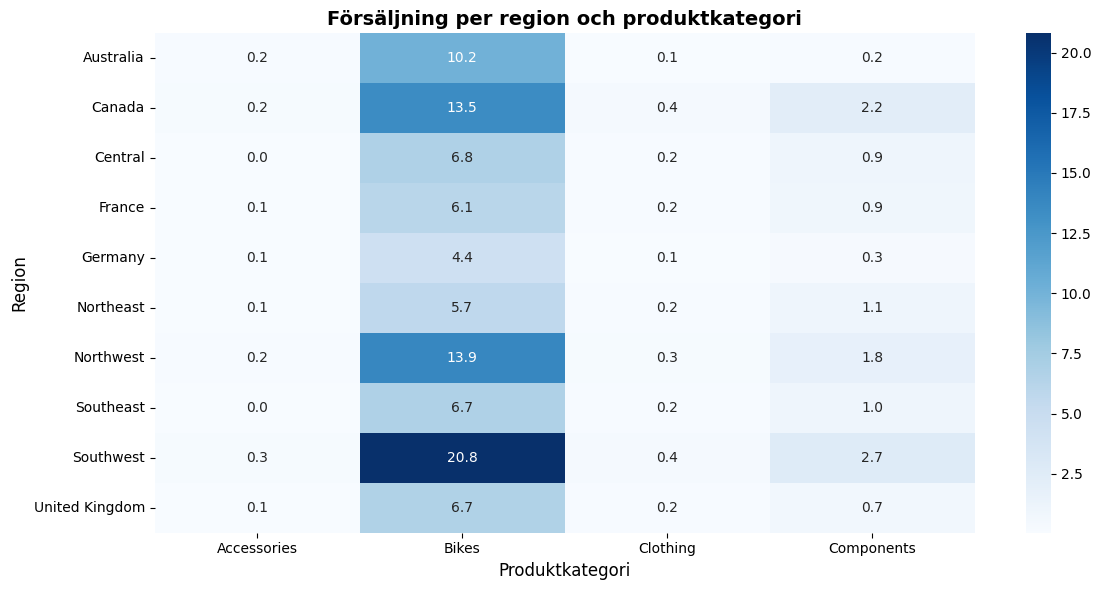

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

sns.heatmap(                            # skapar heatmapen
    pivot_region_category_M,
    annot = True,
    fmt = ".1f",
    cmap = "Blues"
)

plt.title("Försäljning per region och produktkategori", fontsize = 14, fontweight = "bold" )
plt.xlabel("Produktkategori", fontsize = 12)
plt.ylabel("Region", fontsize = 12)

plt.tight_layout()
plt.show()

### Insikter :

- **Bikes** är den **dominerande produktkategorin** i ovan nämnda regionerna. Företaget är mest koncentrerad till cyklar.
- **Southwest** är den **starkaste regionen** med högst försäljning inom både Bikes och Components.
- **Components** fungerar som en **sekundär intäktskälla**, särskilt i regionen med hög cykelförsäljning som Southwest, Northwest och Canada. 
- **Clothing och Accessories** står för en **liten del av försäljningen** i alla regioner, vilket kan indikera potential för förbättrad marknadsföring eller ett behov av att omvärdera sortimentet. 

In [ ]:
# Finns säsongsmönster per region?

query_visA = """

SELECT
    st.Name AS RegionName,
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    CAST(SUM(TotalDue) AS decimal(18,2)) AS TotalSales
FROM Sales.SalesOrderHeader soh  
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY
    FORMAT(OrderDate, 'yyyy-MM'), st.Name
ORDER BY
    YearMonth ASC, RegionName ASC;

"""

df_visA = query_df(query_visA)

In [22]:
df_season = df_visA.copy()

df_season["YearMonth"] = pd.to_datetime(df_season["YearMonth"])

pivot_region_month = df_season.pivot_table(
    index = "YearMonth",
    columns = "RegionName",
    values = "TotalSales",
    aggfunc = "sum"
).sort_index()

pivot_region_month_M = pivot_region_month / 1_000_000

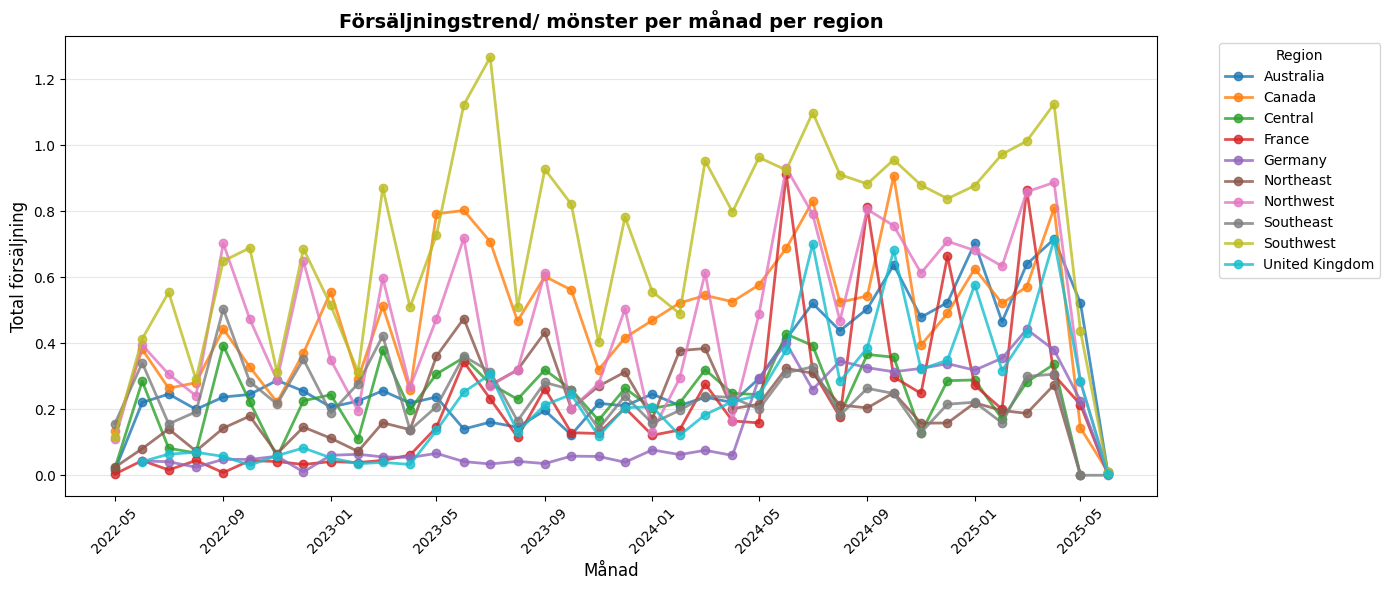

In [23]:
# linjediagram för alla regioner:

fig, ax = plt.subplots(figsize = (14,6))

for region in pivot_region_month_M.columns:
    ax.plot(pivot_region_month_M.index, pivot_region_month_M[region], marker = "o", linewidth = 2, alpha = 0.8, label = region)

ax.set_title("Försäljningstrend/ mönster per månad per region", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Månad", fontsize = 12)
ax.set_ylabel("Total försäljning", fontsize = 12)
ax.grid(True, axis = "y", alpha = 0.3)
ax.legend(title = "Region", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


Vid visualiseringen av alla regioner ser vi många linjer som orsakar **visuellt brus**. Det är ganska svårt att följa en region över tid. Därför är det bäst att visualisera top 3 regioner istället.

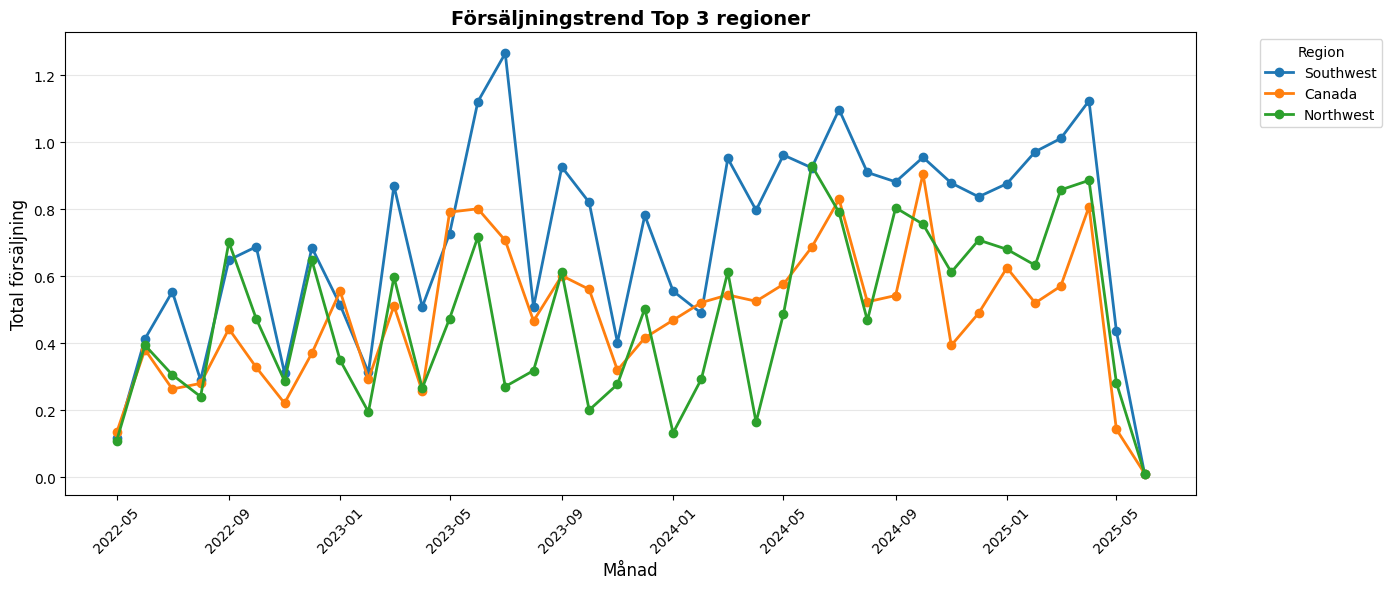

In [24]:
# då diagramet ovan ser lite rörigt ut, testar jag top 3 regioner istället:

top_regions = df_season.groupby("RegionName")["TotalSales"].sum().sort_values(ascending = False).head(3).index

fig, ax = plt.subplots(figsize = (14,6))

for region in top_regions:
    ax.plot(pivot_region_month_M.index, pivot_region_month_M[region], marker = "o", linewidth = 2, label = region)

ax.set_title("Försäljningstrend Top 3 regioner", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Månad", fontsize = 12)
ax.set_ylabel("Total försäljning", fontsize = 12)
ax.grid(True, axis = "y", alpha = 0.3)
ax.legend(title = "Region", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

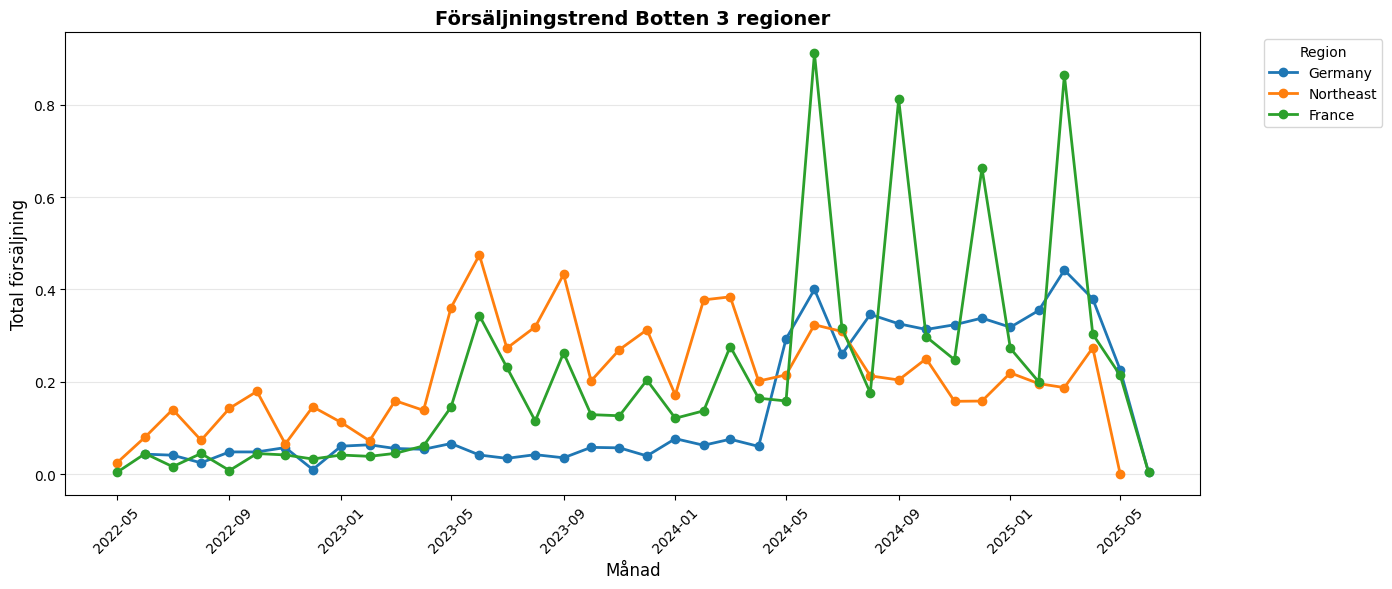

In [25]:
# jag vill även kunna se 3 botten regioner:

bottom_regions = df_season.groupby("RegionName")["TotalSales"].sum().sort_values(ascending = True).head(3).index

fig, ax = plt.subplots(figsize = (14,6))

for region in bottom_regions:
    ax.plot(pivot_region_month_M.index, pivot_region_month_M[region], marker = "o", linewidth = 2, label = region)

ax.set_title("Försäljningstrend Botten 3 regioner", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Månad", fontsize = 12)
ax.set_ylabel("Total försäljning", fontsize = 12)
ax.grid(True, axis = "y", alpha = 0.3)
ax.legend(title = "Region", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Insikter - Säsongsmönster per region

- **Southwest** är tydligt den **starkaste regionen övertid** med högst totalförsäljning nästan varje månad! Regionen visar även en stabil uppåtgående trend / försäljning från 2023 till 2025, vilken kan betyda en stark och växande marknad. 
- **Canada och Northwest** följer Southwest som **näst starkaste regioner** men med något större variation mellan månaderna. Detta kan bero på större säsongsberoende eller kampanjdriven försäljning. 
- I ovannämnda toppregioner syns ändå återkommande **toppar under vår och tidig höst** vilken bevisar ett tydligt **säsongsmönster**. Det måste ha en koppling till cykelsäsong, bättre väder och högre efterfrågan på produkter. 
- **Lägre försäljning** ses ofta under **vintermånader**. Det stärker hypotesen om att efterfrågan är väder och säsongsstyrd. Tror inte att den beror av en slump.
- När alla regioner visualiseras samtidigt i en graf så uppstår visuellt brus. Det gör svårt att följa trenderna men mönstret blev betydligt tydligare och lättare att tolka för mig, när jag valde att fokusera på Top 3 regioner istället. 

In [ ]:
# Försäljning per region uppdelat på produktkategori:

query_visA = """

SELECT 
    st.Name AS Region,
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY st.Name, pc.Name;

"""

df_visA = query_df(query_visA)

In [27]:
pivot_region_category_grouped = df_visA.pivot_table(
    index = "Region",
    columns = "Category",
    values = "TotalSales",
    aggfunc = "sum"
) / 1_000_000

In [28]:
# behöver göra min pivot lite mer stabil
pivot = pivot_region_category_grouped.fillna(0)                                 # fyller NAN om någon region saknar kategori
pivot["Total"] = pivot.sum(axis = 1)                                            # behöver sortera regioner efter den totala försäljningen 
pivot = pivot.sort_values("Total", ascending=False).drop(columns="Total")

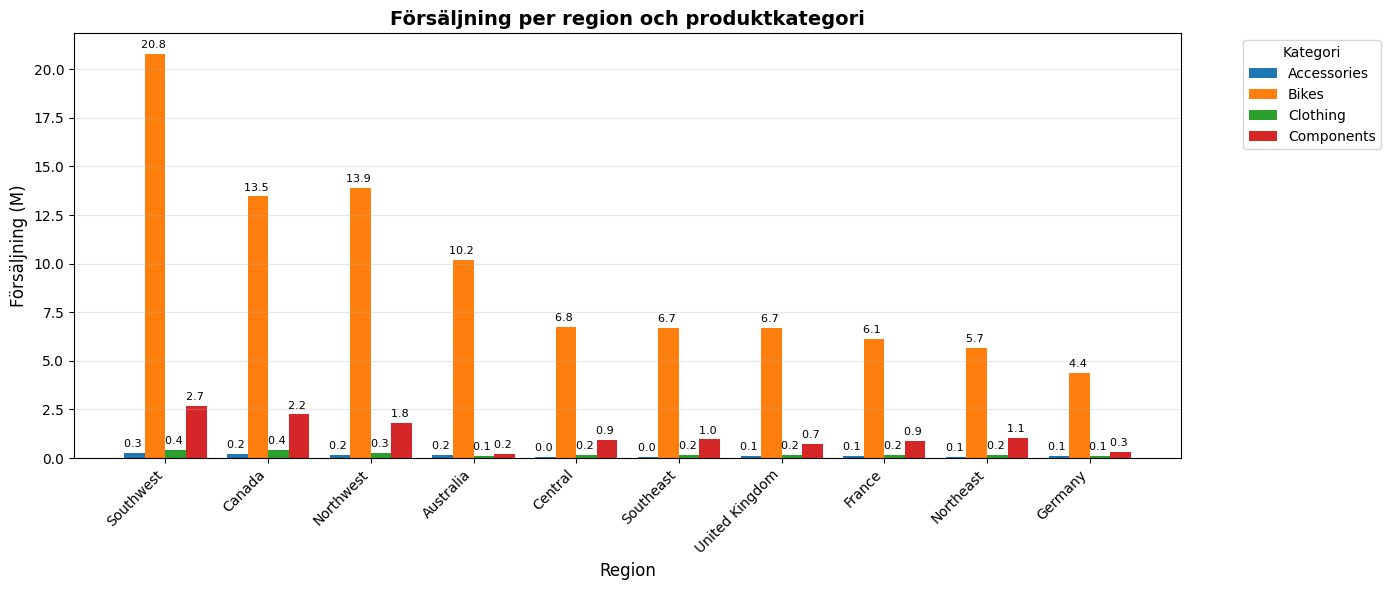

In [32]:
# grouped bar figuren :

regions = pivot.index
categories = pivot.columns
x = np.arange(len(regions))
n = len(categories)
width = 0.8 /n 

fig, ax = plt.subplots(figsize=(14,6))
for i, cat in enumerate(categories):
    bars = ax.bar(
        x + (i -(n-1)/2) * width,                   # här tänker jag flytta varje kategori lite åt sidan
        pivot[cat],
        width = width,
        label = cat
    )
    for b in bars:
        h = b.get_height()
        ax.text(
              b.get_x() + b.get_width()/2,
              h + 0.2,
              f"{h:.1f} ",
              ha = "center",
              va = "bottom",
              fontsize = 8
        )


ax.set_title("Försäljning per region och produktkategori", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Region", fontsize = 12)
ax.set_ylabel("Försäljning (M)", fontsize = 12)

ax.set_xticks(x)
ax.set_xticklabels(regions, rotation = 45, ha = "right")
ax.grid(True, axis = "y", alpha = 0.3)
ax.legend(title = "Kategori", bbox_to_anchor = (1.05, 1), loc = "upper left")

plt.tight_layout()
plt.show()

# Sammanfattning :
1. *Vilken region presterar bäst/sämst ?*
- **Starkast är Southwest** som har höst total försäljning (drivs framförallt av Bikes).
- **Svagast: Germany** som ligger lägst i total försäljning (och även låg volym jämfört med toppregionerna).
- Southwest är en tydlig motor-region, medan Germany/France/Notheast är stora utvecklingsområden.

2. *Vilka produktkategorier säljer bäst och var ?*
- **Bikes dominerar** i alla regioner men särskilt starkt i Southwest, Northwest och Canada.
- **Components är ofta på andra platsen** men långt efter Bikes- sticker mest ut i Southwest och Canada.
- **Clothing / Accessories är små** i alla regioner och fungerar kanske mer som tilläggsprodukter än huvuddrivare i omsättningen.

3. *Finns säsongsmönster per region ?*
- Top 3 regioner visar tydliga toppar och dalar över året, vilket **tyder på säsong** (tex. cykelsäsong).
- Svagare regioner (ex. France/Northeast) har mer ojämn och lägre nivå, vilket kan bero på mindre marknader, lägre efterfrågan eller svagare marknadsföring. 

*Sista månaden kan vara ofullständigt då man ser att kurvan krashar vid sista punkten.*


### Rekommendationer

- Planera marknadsföringskampanjer och lageruppbyggnad inför vår och höst, då efterfrågan är som högst.
- Fortsätt att prioritera Southwest, som kombinerar hög försäljning och stabil tillväxt. 
- Analysera varför vissa regioner (France och Northeast) har betydligt svagare och mer ojämn försäljning- det kan tex. bero på marknadsstorlek snarare än låg köpkraft.
- Använd säsongsmönstren för att optimera driften: personalplanering, logistik, kampanjer per region. 
- Säkra Bikes i toppregionerna. Planera lager, kampanjer och leveranskapacitet eftersom Bikes driver majoriteten av intäkterna. 
- Lägg extra fokus på Components. Eftersom Bikes säljer stark, kan man höja intäkt per order med hjälp av en extra vara, tex. Bike + hjälm + reservdelar (merförsäljning som ökar varor per kvitto).
- Identifera varför Germany/ France / Northeast ligger lågt. En uppföljningsannalys kanske ?
- Om vissa regioner har relativt högre Clothing/ Accessories- andel och omsättning: observera regionens beteende, kundmönster, snittkvitto för att implementera förändringar i andra regioner för att öka deras försäljning i dessa områden. 


# Reflektioner :

1. Jag valde Försäljningsoptimeringen som djupanalys eftersom jag märkte ganska snabbt att försäljningen skiljer sig kraftigt mellan regionerna, både i nivå och mönster över tid. Mitt val var att förstå **vilka regioner som driver försäljningen**, vilka som underpresterar samt vilka produktkategorier som är viktigast i respektive region. På mitt förra jobb följde vi upp väldigt liknande KPIer och använde en hel del säsongsmönster i butiker över hela Sverige men även jämförde Sverige med resten av världen inom företaget för att planera bättre och fatta vettiga beslut.

2. Jag valde att göra aggregeringar i SQL såsom: SUM, COUNT, GROUP BY, eftersom:
- SQL är jätteeffektivt för att arbeta med stora datamängder direkt i databasen
- Det minskar mängder data som behöver laddas i pandas
- Affärslogiken blev mycket tydligare och lättare att spåra

Pandas använde jag för **analys, omformning (pivot) och visualisering**. Det kändes mycket mer flexibelt och lättare att experimentera enligt mig. 

3. Jag valde diagramtyper utifrån vilken fråga som skulle besvaras, mycket baserat på lärarens förslag, dvs:
- Heatmap region x kategori där man kunde snabbt se vilka kombinationer som dominerar
- Linjediagram per månad för att lättare kunna se med ögat säsongsmönster och trender över tid
- Grupperad stapeldiagram för att jämföra produktkategorier mellan regioner som gav en tydlig överblick. 

Jag upplevde att genom att kombinera olika diagramtyper upprepades man inte, visade inte samma sak flera gånger, och det gav mig mera detaljer på ett roligare sätt.

4. Pivot tables var avgörande för att:
- Det omvandlade lång data till matriser som är lättare att jämföra
- De hjälpte att se sambandet mellan **region, kategori och tid**. Formatet blev direkt mycket lättare att visualisera.
- Dessa indentiferade vilka kategorier som faktiskt driver försäljning per region. Utan pivot tables hade varje min analys krävt mer komplexa kod och varit svårare för mig att tolka visuellt.

5. Utmaningarna jag stötte på:
- **Att första JOINs mellan många tabeller** --> löste genom att stegvist bygga queries och testa delresultat. Många tabeller i databasen som gör en förvirrad i början. Att visualisera de i en diagram hjälpte lite. 
- **Visuellt brus i linjediagram med många regioner** --> jag löste det genom att fokusera på TOP 3 och Bottom 3 regioner.
- **Mina visualiseringar blev många gånger otydliga eller felaktiga** --> jag justerade succesivt med hjälp av legend, etiketter och diagramtyp, testade mig fram helt enkelt och tog mycket inspiration och kunskap från förra Python kursen där vi gick igenom noga MATPLOTLIB.
- **Att förstå skillnaden mellan aggregering i SQL och pandas** --> blev tydligare för mig genom det praktiska arbetet i examinerande uppgiften.

6. Utifrån min analys, rekommenderar jag:
- Fortsätt hålla fokus på kategorin Bikes i toppregionerna
- Fokusera mer på merförsäljning av Components och Accessories ( det gå lätt att koppla till Bike-köp som ökar snittkvitto och antal varor per kvitto)
- Det behövs en fördjupning / ny analys av svaga regioner för att avgöra om problemet är efterfrågan, marknadsnärvaro eller kanske sortimentet ?
- Säsonganpassad planering är A och O. Planering av kampanjer utifrån månadsmönster.
- Kanske fundera över mer regionalt anpassat sortiment ? Istället för en massfördelning av samma varor till alla butiker. Testa lite olika strategier där. 